In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import h5py
import tensorflow.keras.backend as K
import re
%matplotlib inline 

# Throw away lepton mass 

be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

dataset = be1

input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  100000 

In [2]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]


def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 

def phi3_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    return np.sin(w) - 1.2*(1-exist), np.cos(w) - 2.2*(1-exist) 
    
def invphi3_transform(z1, z2, max0, mean, exist):
    w1 = z1 + 1.2*(1-exist)
    w2 = z2 + 2.2*(1-exist)
    w = np.arctan2(w1, w2)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr

def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    names = []
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            zsin, zcos = phi3_transform(var, max0, mean, exist)
            arrays.append(zsin)
            arrays.append(zcos)
            names.append(key +'-sin')
            names.append(key + '-cos')
        else:
            if key in pt_keys:
                max0, mean = maxmean_dict['pt']
                z = pt_transform(var, max0, mean)
            elif key in m_keys:
                max0, mean = maxmean_dict['m']
                z = pt_transform(var, max0, mean)
            else:
                max0, mean = maxmean_dict[key.split('_')[1]]
                z = meanmax_transform(var, max0, mean)
            arrays.append(z)
            names.append(key)
    arrays = np.stack(arrays, axis=1)
    return arrays, names

def invscale_arrays(keys, arrays, maxmean_dict, names):
    exist_dict = jet_existence_dict()
    total = []
    i = 0
    while i< arrays.shape[1]:
        full_key = names[i]
        key = names[i].split('_')[1]
        if key[0:3] == 'phi':
            zsin = arrays
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[full_key.split('-')[0]]
            zsin = arrays[:,i]
            zcos = arrays[:,i+1]
            total.append(invphi3_transform(zsin, zcos, max0, mean, exist))
            i+=2
        else:
            z=arrays[:,i]
            if key == 'pt':
                max0, mean = maxmean_dict[key]
                total.append(invpt_transform(z, max0, mean))
            elif key=='m':
                max0, mean = maxmean_dict[key]
                total.append(invpt_transform(z, max0, mean))
            else:
                max0, mean = maxmean_dict[key]
                total.append(invmeanmax_transform(z, max0, mean))
            i+=1
    return np.stack(total,axis=1) 

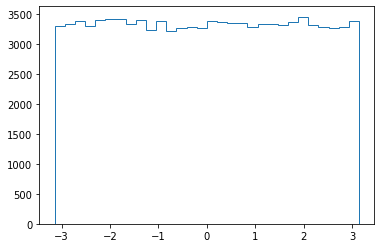

In [3]:
var = dataset.get('th_phi')[0:crop0]

plt.hist(var, 30, histtype='step')
plt.show()

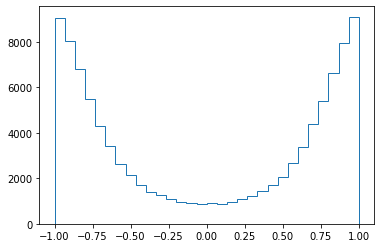

In [4]:
max0, mean0, exist = np.pi, 0.0, np.ones(var.size)

phi1_var = phi1_transform(var, max0, mean0, exist)
plt.hist(phi1_var, 30, histtype='step')
plt.show()

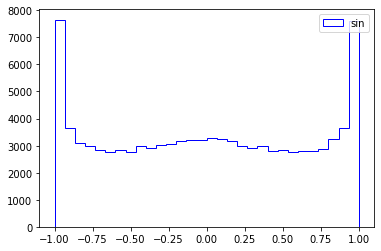

In [5]:
sin_var, cos_var = phi3_transform(var, max0, mean0, exist)
plt.hist(sin_var, 30, histtype='step', color='b', label='sin')
# plt.hist(cos_var, 30, histtype='step', color='r', label='cos')
plt.legend()
plt.show()

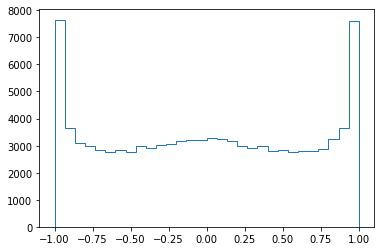

In [6]:
sin0_var = np.sin(phi1_var*np.pi)
plt.hist(sin0_var, 30, histtype='step')
plt.show()

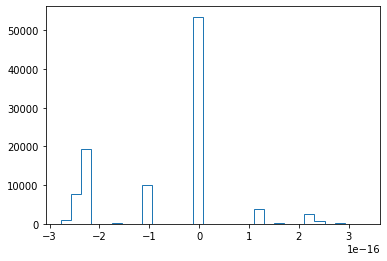

In [7]:
plt.hist(sin0_var-sin_var, 30, histtype='step')
plt.show()

In [8]:
def phi4_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    sin = 2/np.pi*np.arcsin(np.sin(w)) - 1.2*(1-exist)
    cos = 2/np.pi*np.arcsin(np.cos(w)) - 2.2*(1-exist)
    return (sin, cos)

def invphi3_transform(z1, z2, max0, mean, exist):
    w1 = z1 + 1.2*(1-exist)
    w2 = z2 + 2.2*(1-exist)
    w = np.arctan2(w1, w2)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr

def invphi4_transform(z, max0, mean, exist):
    pi = np.pi
    sin, cos = z[0] + 1.2*(1-exist), z[1] + 2.2*(1-exist)
    sin0, cos0 = np.sin(pi/2*sin),  np.sin(pi/2*cos)
    w = np.arctan2(sin0, cos0)
    x = (w + lep_phi*exist) % (2*pi)
    x = x-2*np.pi*(x>pi)
    return x
    

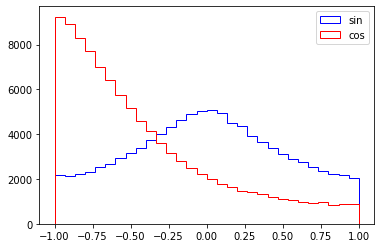

In [9]:
sin1_var, cos1_var = phi4_transform(var, max0, mean0, exist)
plt.hist(sin1_var, 30, histtype='step', color='b', label='sin')
plt.hist(cos1_var, 30, histtype='step', color='r', label='cos')
plt.legend()
plt.show()

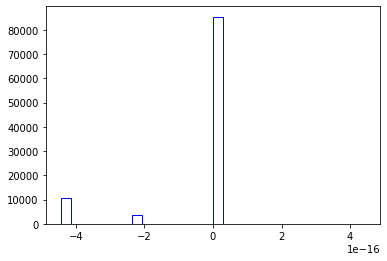

In [10]:
inv_phi4 = invphi4_transform(phi4_transform(var, max0, mean0, exist), max0, mean0, exist)
plt.hist(inv_phi4 - var, 30, histtype='step', color='b')
plt.show()